##  tensorflow2 implementation 
Thanks to  https://www.pluralsight.com/guides/artistic-neural-style-transfer-with-tensorflow-2.0:-theory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# importing the libraries
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
import os
import numpy as np
import PIL.Image
import time
import functools
path = '/content/drive/MyDrive/Colab Notebooks/deep_learning/project'
os.chdir(path)
def tensor_to_image(tf_input):
    tf_input = tf_input*255
    tf_input = np.array(tf_input, dtype=np.uint8)
    if np.ndim(tf_input)>3:
        assert tf_input.shape[0] == 1
        tf_input = tf_input[0]
    return PIL.Image.fromarray(tf_input)

#input image of your choice
content_path = 'images/mm.jpeg'
content_path = 'images/mountain.jpg'
#content_path = 'images/wtc_day.jpg'
style_path = 'images/waves.jpeg'
style_path = 'images/composition-vii.jpeg'
style_path = 'images/fall_colour_red.jpg'
style_path = 'images/cherry_blossom_white_1.jpg'
output_image_path = 'output_image.png'

In [3]:
def load_img(image_path):
    max_dim = 512
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)#Detects the image to perform apropriate opertions
    img = tf.image.convert_image_dtype(img, tf.float32)#converts image to tensor dtype

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)# Casts a tensor to float32.

    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)

    return img[tf.newaxis, :]

In [4]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

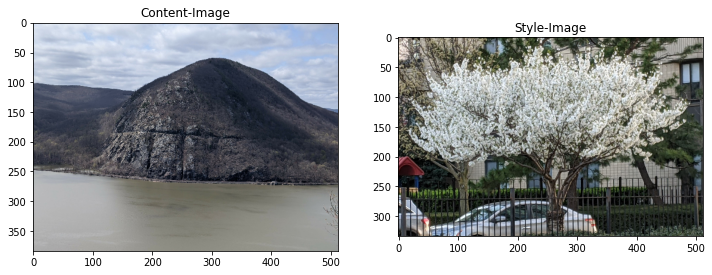

In [5]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content-Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style-Image')

In [6]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 4s 0us/step


TensorShape([1, 1000])

In [7]:
content_layers = ['block4_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [8]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    tf_outs = [vgg.get_layer(layer).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], tf_outs)
    return model

In [9]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, tf_out in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", tf_out.numpy().shape)
    print("  min: ", tf_out.numpy().min())
    print("  max: ", tf_out.numpy().max())
    print("  mean: ", tf_out.numpy().mean())
    print()

80142336/80134624 [==============================] - 2s 0us/step
block1_conv1
  shape:  (1, 334, 512, 64)
  min:  0.0
  max:  846.1054
  mean:  31.131453

block2_conv1
  shape:  (1, 167, 256, 128)
  min:  0.0
  max:  3772.0647
  mean:  201.08028

block3_conv1
  shape:  (1, 83, 128, 256)
  min:  0.0
  max:  9013.565
  mean:  177.55919

block4_conv1
  shape:  (1, 41, 64, 512)
  min:  0.0
  max:  20944.084
  mean:  595.88196

block5_conv1
  shape:  (1, 20, 32, 512)
  min:  0.0
  max:  2509.3533
  mean:  38.67535



In [10]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [11]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [12]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  2.8823184e-05
    max:  29903.502
    mean:  352.3154

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  59105.047
    mean:  9284.826

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  194939.23
    mean:  7061.2207

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  1475262.4
    mean:  118268.09

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  88581.16
    mean:  673.3792

Contents:
   block4_conv2
    shape:  (1, 48, 64, 512)
    min:  0.0
    max:  10564.558
    mean:  187.40479


In [13]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [14]:
image = tf.Variable(content_image)

In [15]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [16]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [17]:
style_weight=1e-2
content_weight=1e4

In [18]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [19]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

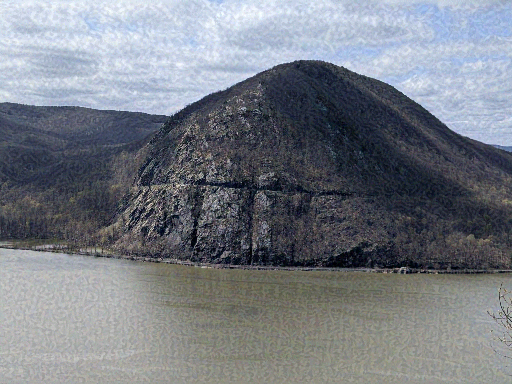

In [20]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

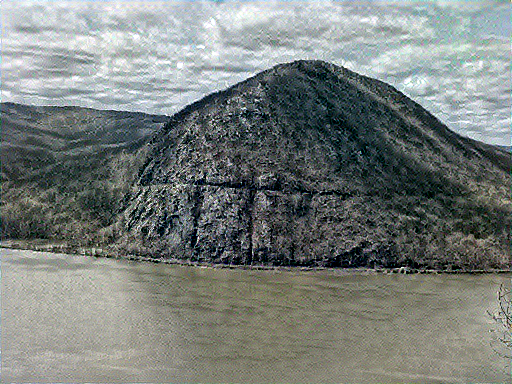

Train step: 1210
Total time: 8.1


In [21]:
import time
start = time.time()

epochs = 11
steps_per_epoch = 10

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 11
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    x = tensor_to_image(image)
    
    x.save("output_image_mnt_1.png")
    display.display(tensor_to_image(image))

    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

<function matplotlib.pyplot.show>

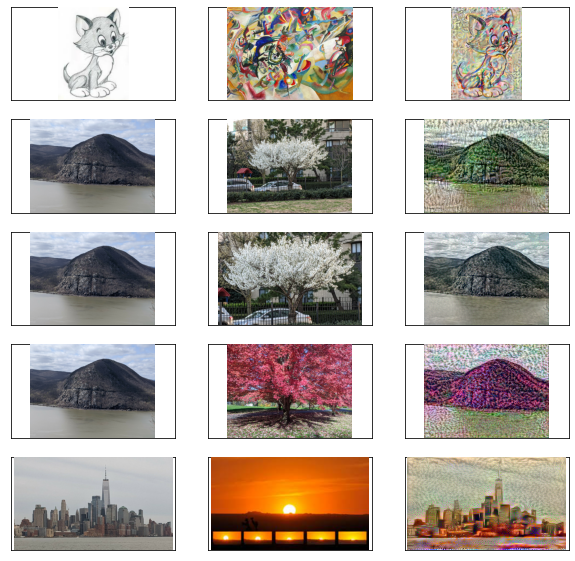

In [22]:
content_image_set = ['images/mm.jpeg',
                     'images/mountain.jpg',
                     'images/mountain.jpg',
                     'images/mountain.jpg',
                     'images/wtc_day.jpg'
                     ]
style_image_set = ['images/composition-vii.jpeg',
                   'images/cherry_blossom_white.jpg',
                   'images/cherry_blossom_white_1.jpg',
                   'images/fall_colour_red.jpg',
                   'images/sunset_scene.jpeg']
output_image_set = ['output_image_mm.png',
                    'output_image_mnt.png',
                    'output_image_mnt_1.png',
                    'output_image_mnt_pink.png',
                    "output_image_wtc_eve.png"]
nrows = len(content_image_set)
ncols = 3
cnt = 1
fig,axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))


for c,s,o in zip(content_image_set,style_image_set,output_image_set):
  
  content_image = load_img(c)
  style_image = load_img(s)
  output_image = load_img(o)

  fig.add_subplot(nrows, ncols, cnt)
  plt.imshow(content_image[0])
  plt.axis('off')
  plt.box(False)
  cnt +=1


  fig.add_subplot(nrows, ncols, cnt)
  #plt.subplot(nrows, ncols, cnt)
  plt.imshow(style_image[0])
  plt.axis('off')
  cnt +=1

  
  plt.axis('off')
  fig.add_subplot(nrows, ncols, cnt)
  plt.axis('off')
  #plt.subplot(nrows, ncols, cnt)
  plt.imshow(output_image[0])
  plt.axis('off')
  plt.box('off')
  cnt +=1

  for ax in axes.flat:
           
            ax.set_xticks([])
            ax.set_yticks([])
            

plt.axis('off')
plt.show